In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import seaborn as sns
from scipy import stats

import os
import joblib
import pickle
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from joblib import dump



sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
import plot_helpers

In [3]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    # monthlist = ['DEC17','JAN18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    # Cancel unallowed values (coolin rate positve)
    df[df['tmeltsi']>0] = 0
    df[df['tsubsi']>0] = 0
    df[df['tevr']>0] = 0

    return df

df_train = load_data('train')
df_val = load_data('val')

Concatente all df to one
Concatente all df to one


In [4]:
## Drop unnecessary columns
cols_target_features = ['tevr', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']

df_train = df_train[cols_target_features]
df_val = df_val[cols_target_features]


In [5]:
print(df_train.shape)
print(df_val.shape)

(99952833, 8)
(14438680, 8)


In [6]:
# Old df_train.shape and 
# (138658804, 7)    (old)
# ( 99952833, 7)    (new)

# df_val.shape
# (14548323, 7)     (old)
# (14438680, 7)     (new)

In [7]:
df_tevr_train = rf_functions.apply_domainfilter(df=df_train,
                                                  water_type='RWC',
                                                  verbose=1,
                                                  temp_filter=False,
                                                  output_filter=False)

Drop all points where RWC == 0


In [8]:
df_tevr_val = rf_functions.apply_domainfilter(df=df_val,
                                                water_type='RWC',
                                                verbose=1,
                                                temp_filter=False,output_filter=False)

Drop all points where RWC == 0


In [9]:
# Define the predictors and the target
target = 'tevr'

X_train = df_tevr_train.drop([target], axis=1)
y_train = df_tevr_train[target]

X_val = df_tevr_val.drop([target], axis=1)
y_val = df_tevr_val[target]

In [10]:
df_train[X_train.columns].describe()

,SIWC,LWC,RWC,RH,Q,OMEGA,T
count,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07
mean,6.646162e-03,2.504825e-03,6.648872e-04,1.274297e+01,3.822144e-04,-1.977584e-02,-1.104258e+01
std,4.433433e-02,1.935200e-02,9.133182e-03,2.570297e+01,1.276379e-03,1.570743e-01,1.916656e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.261989e+01,-9.121857e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.286819e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,2.414006e+00,3.436481e-06,0.000000e+00,0.000000e+00
max,6.370396e+00,1.511991e+00,2.368629e+00,1.362414e+02,2.178455e-02,9.686302e+00,4.174277e+01


In [11]:
X_train.describe()

,SIWC,LWC,RWC,RH,Q,OMEGA,T
count,3.573622e+06,3.573622e+06,3.573622e+06,3.573622e+06,3.573622e+06,3.573622e+06,3.573622e+06
mean,3.151888e-02,3.699474e-02,1.859664e-02,8.606243e+01,5.563442e-03,-1.152256e-01,5.237624e+00
std,1.186691e-01,7.400769e-02,4.497316e-02,1.264793e+01,2.337303e-03,4.185328e-01,5.162598e+00
min,0.000000e+00,0.000000e+00,1.455192e-08,7.936431e-02,7.907917e-06,-1.261989e+01,-4.045486e+01
25%,0.000000e+00,0.000000e+00,4.768372e-04,7.899174e+01,4.046909e-03,-1.851453e-01,1.370270e+00
50%,0.000000e+00,9.536743e-04,2.816319e-03,8.842910e+01,4.805643e-03,-4.130602e-02,3.436249e+00
75%,2.082437e-03,3.518164e-02,1.634657e-02,9.683513e+01,6.351951e-03,2.863428e-02,8.031769e+00
max,6.370396e+00,1.511991e+00,2.368629e+00,1.362414e+02,2.178455e-02,5.179511e+00,3.245425e+01


In [12]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

In [13]:
X_train.columns

Index(['SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T'], dtype='object')

In [14]:
model_name = 'rf_fulldata_gridsearch'
filepath = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tevr/{model_name}.joblib"


if os.path.isfile(filepath) or input('Rerun model? (y/n)') == 'n':
    print('Load Model')
    path = f'/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tevr/{model_name}_f1.joblib'
    best_model_f1 = joblib.load(f'{path}')
else:
    doublecheck = input('Do you want to run the model?  (yes/no)')
    if doublecheck == 'yes':
        # Define the hyperparameters for grid search

        param_grid = {
            'n_estimators'      : [500],
            'max_depth'         : [200],
            'max_features'      : [3],
            'min_samples_split' : [6],
            'min_samples_leaf'  : [20],
            'criterion'         : ['squared_error']
        }

        # Call the function
        best_model_mse, best_params_mse, best_model_f1, best_params_f1 = rf_functions.grid_search_with_validation_set_f1(X_train=X_train,
                                                                                                                         y_train=y_train,
                                                                                                                         X_val=X_val,
                                                                                                                         y_val=y_val,
                                                                                                                         param_grid=param_grid,
                                                                                                                         save_name=model_name, 
                                                                                                                         threshold=-0.1
                                                                                                                         )

Load Model


In [15]:
y_pred = best_model_f1.predict(X_val)

In [16]:
residuals = y_val - y_pred

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)


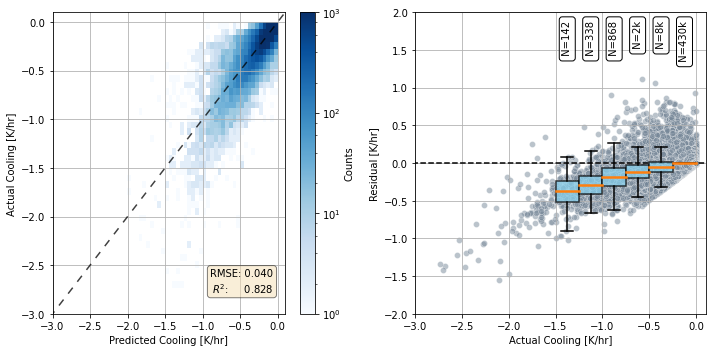

In [17]:
process = 'tevr'


xrange = -3
yrange = 2

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_pred, y_val, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Predicted Cooling [K/hr]')
ax[0].set_ylabel('Actual Cooling [K/hr]')
ax[0].set_xlim(-3, 0.1)
ax[0].set_ylim(-3, 0.1)
ax[0].plot([-5,1], [-5,1], linewidth=1.5, c='k', linestyle='--', dashes=(5,5), alpha=0.75)

# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Counts')
# Set logarithmic colorbar ticks 
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.3f}\n$R^2$:     {r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.95, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           ha='right', va='top', bbox=props)
ax[0].grid(zorder=0)
# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, alpha=0.5, color='lightslategray', ax=ax[1])
ax[1].set_ylabel('Residual [K/hr]')
ax[1].set_xlabel('Actual Cooling [K/hr]')
ax[1].set_xlim(xrange, 0.1)
ax[1].set_ylim(-yrange, yrange)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plot_helpers.add_boxplots(x=y_val,y=residuals, ax=ax[1], width_boxplot=0.25, min_points_boxplot=100, count_per_boxplot=True, fontsize_text=10, input_detail_mode=False)
plt.tight_layout()
plt.grid(zorder=0)
plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/tevr_predVStrue_resid.png',dpi=200)

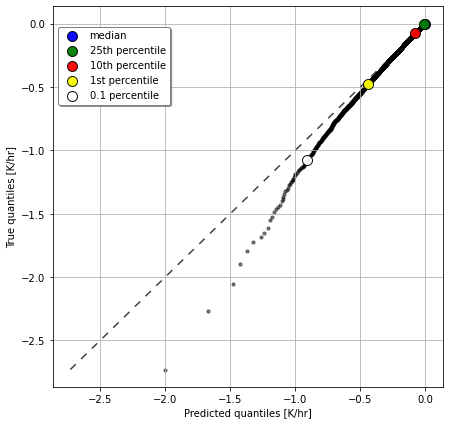

In [18]:
fig, ax = plt.subplots(figsize=(7,7))

nr_points = plot_helpers.plot_modified_qq_plot(ax=ax, y_pred=y_pred, y_true=y_val, subsample_factor=0.1)
# plt.title(f'QQ plot: tmeltsi (# qunatiles: {nr_points:2.1e} from {len(y_pred):2.1e} total samples)')
plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/tevr_QQplot.png',dpi=200)
plt.show()


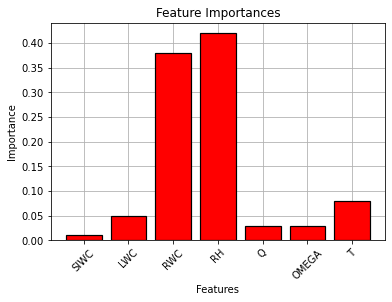

In [38]:
# Get numerical feature importances
importances = list(best_model_f1.feature_importances_)

# List of tuples with variable and importance and sort them
feature_list = list(X_train.columns) 
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# list of x locations for plotting
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

x_values = list(range(len(importances)))# Make a bar chart
plt.grid(zorder=0)
plt.bar(x_values, sorted_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2, zorder=2)
plt.xticks(x_values, sorted_features, rotation=45)# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Feature Importances')

# plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/tevr_feature_importance.png',dpi=200)
save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tevr_feat_imp'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')

In [21]:
from sklearn.inspection import (partial_dependence, 
                                PartialDependenceDisplay)
from sklearn.inspection import plot_partial_dependence

In [20]:
feature_indices = [feature_list.index(feature) for feature in ['RWC','RH','T']] 
feature_indices

[2, 3, 6]

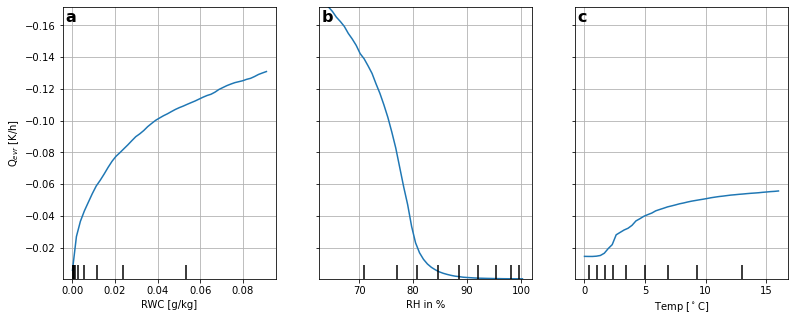

In [27]:
xlabel_list = ['RWC [g/kg]', 'RH in %', r'Temp [$^\circ$C]']

fig,axs = plt.subplots(nrows=1,ncols=3, figsize=(13,5), sharey=True)
imgs = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_indices, grid_resolution=50, ax=axs)

axs[0].set_ylabel(r'Q$_{evr}$ [K/h]')
for i in range(3):
    if i !=0:
        axs[i].set_ylabel('')
    axs[i].set_xlabel(xlabel_list[i])
    axs[i].invert_yaxis()


## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    axs[col].grid(zorder=1)
    label= labels[col]
    axs[col].text(0.012, 0.99, label, transform=axs[col].transAxes, fontsize=16, fontweight='bold', va='top')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tevr_pdp_single'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
from itertools import combinations

# Generating all possible combinations of 2 features from the list of 7 features
feature_combinations = list(combinations(feature_indices, 2))
feature_combinations 

[(2, 3), (2, 6), (3, 6)]

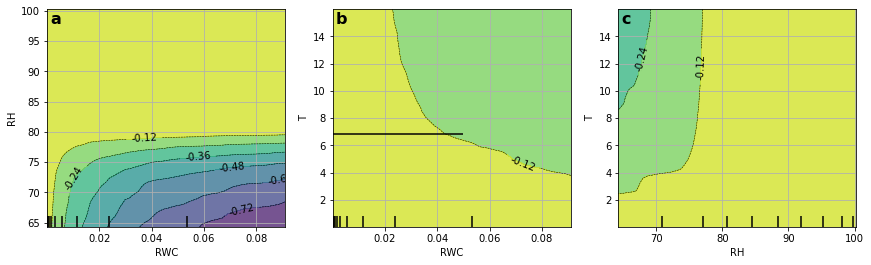

In [28]:
if len(feature_combinations)<=3:
    cols = int(len(feature_combinations))
    fig,axs=plt.subplots(ncols=cols, figsize=(4.5*cols+1,4))
else:
    cols = len(feature_combinations) // 2
    rows = len(feature_combinations) - cols
    fig,axs=plt.subplots(nrows=int(rows), ncols=int(cols), figsize=(5*cols,5*rows))

imgs2d = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_combinations, ax=axs,
                                        grid_resolution=50, feature_names=feature_list)

# Hide decile lines
for ax in axs.flatten():
    for line in ax.lines:
        if line.get_linestyle() == '--':
            line.set_visible(False)

## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    axs[col].grid(zorder=1)
    label= labels[col]
    axs[col].text(0.012, 0.99, label, transform=axs[col].transAxes, fontsize=16, fontweight='bold', va='top')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tevr_pdp_2feat'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
for ax in axs.flatten():
    for collection in ax.collections:
        print(type(collection))  # prints the type of each collection
        # print(collection.get_paths())  # prints the paths of each collection, if available
        # print(collection.get_array())  # prints the array of each collection, if available


<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.LineCollection'>
<class 'matplotlib.collections.LineCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathCollection'>
<class 'matplotlib.collections.PathColle

In [32]:
ax.lines

<Axes.ArtistList of 0 lines>

In [46]:
## Plot a Partial Dependence Plot (PDP)
from sklearn.inspection import (partial_dependence, 
                                PartialDependenceDisplay)

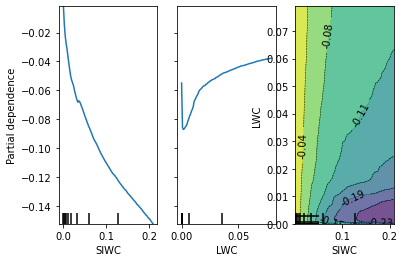

In [23]:
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(best_model_f1, X_val, features, target=0)

In [25]:
# partial_dependence(best_model_f1, X_train, 'RH', kind='average')

{'average': array([[-0.15863036, -0.15802509, -0.15733538, -0.15683304, -0.15622037,
         -0.15542831, -0.1547782 , -0.15398057, -0.15299499, -0.15213546,
         -0.15118205, -0.15012212, -0.14914414, -0.14825456, -0.14730798,
         -0.1463977 , -0.14537556, -0.14398512, -0.1429384 , -0.14178237,
         -0.14051877, -0.13926069, -0.13807479, -0.13676836, -0.13559635,
         -0.13407377, -0.13271846, -0.13104619, -0.12984548, -0.12860955,
         -0.12721404, -0.1256616 , -0.12417735, -0.12266547, -0.12104838,
         -0.11954005, -0.11798682, -0.11684069, -0.11537665, -0.1142568 ,
         -0.11270727, -0.11110874, -0.10975619, -0.11109367, -0.11203847,
         -0.11228343, -0.11097316, -0.10981673, -0.10828597, -0.10702248,
         -0.10554092, -0.10419919, -0.10257229, -0.10101759, -0.09941877,
         -0.09804624, -0.09647754, -0.09455043, -0.09286138, -0.09128499,
         -0.08966685, -0.08816184, -0.08648995, -0.08481847, -0.08319815,
         -0.08186144, -0.08

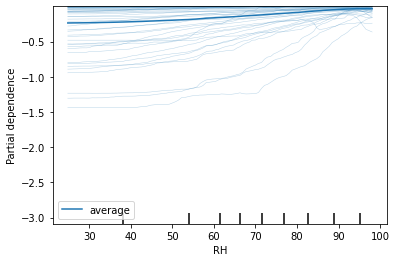

In [26]:
# n = 50
# PartialDependenceDisplay.from_estimator(best_model_f1, X_train, ['RH'], kind="both", n_jobs=60, subsample=n)